# Introduction
This notebook implements Logistic Regression with Gradient Descent. 

- Algorithms: Logistic Regression
- DataSets:   "logistic_regression" 
- Video: To Be Added.


# Logistic Regression
The hypothesis set for logistic regression is

$$ H = \{ \sigma(w^T x) \mid w\in R^{d+1}\} $$

Given data $D=\{(x_1,y_1),...,(x_N, y_N)\}$ we want to minimize the following error function

$$E_{in}(h)=\sum_{i=1}^N...$$

Notice that any hypothesis $h(x)=\sigma(w^Tx)\in H$ is described exactly by is weights $w\in R^{d+1}$. Our goal is to find weights $w$ such that we minimize the in-sample error $E_{in}(w)$. 

Unfortunately, for Logistic Regression we do not have a formula that computes the optimal weights. The gradient can be found [1] to be 

$$\nabla_w E_{in}(w)=..$$

In the code below we use this as a fact. 

# Code: Logistic Regression

<IPython.core.display.Javascript object>


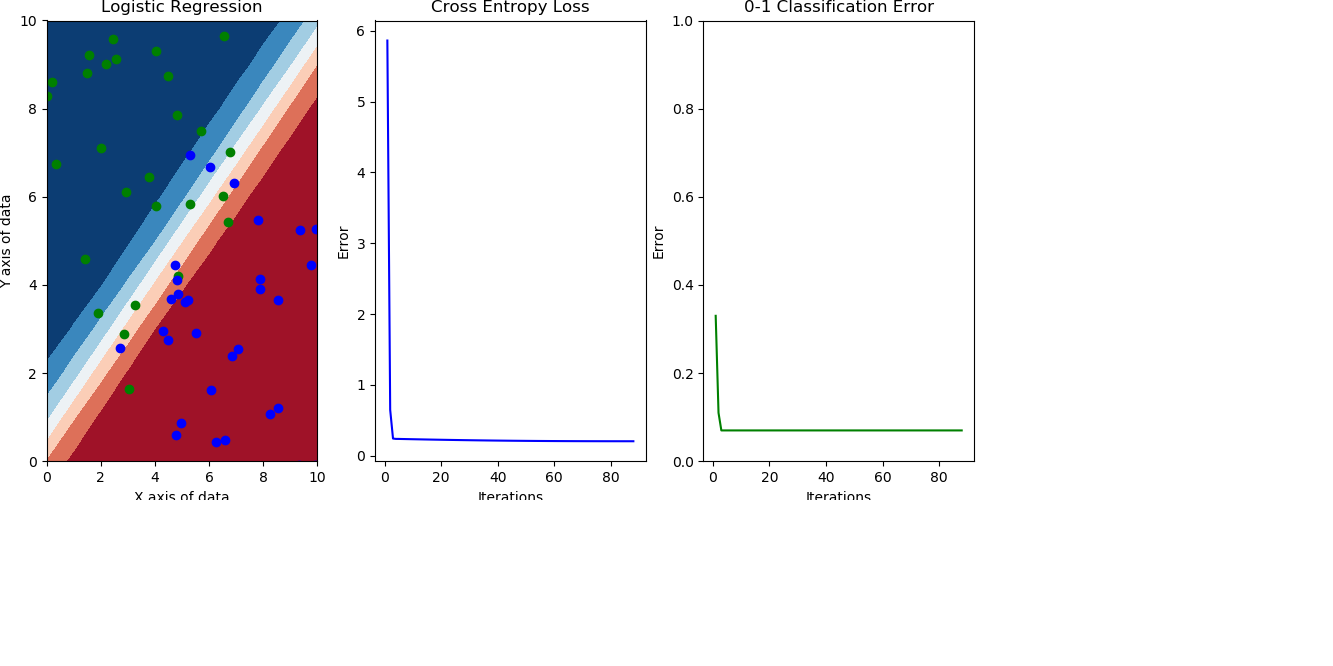

KeyboardInterrupt: 

In [1]:
%matplotlib notebook


import numpy as np
import matplotlib.pyplot as plt
import time
import dataset as ds

class LogisticRegression:
    
    def __init__(self, visualize=False, sleep=0.0):
        self.visualize = visualize
        
        if self.visualize: 
            self.fig, (self.ax_data, self.ax_error, self.ax_error_01) = plt.subplots(1, 3, figsize=(10, 5))
            self.errors = []   
            self.errors_01 = []
            self.sleep = sleep
            self.fig.tight_layout()
    
    def fit(self, X, y, rounds, learning_rate):
        N, d = X.shape
        
        # Initialize weights randomly
        self.w = np.random.rand(d)
        
        # Take 'rounds' steps in the direction of the negative gradient
        for i in range(rounds):
            # Compute Gradient
            gradient = self.gradient(X, y)
            
            # Update weights
            self.w = self.w - learning_rate * gradient
            
            # Visualize if enabled. 
            if self.visualize: self.do_visualize(X, y)
      
    
    def sigmoid(self, x):
        return 1/(1+np.exp(x))
    
    def gradient(self, X, y): 
        return X.T @ (y - self.sigmoid(X @ self.w))
    
    def predict(self, X):
        return self.sigmoid(X @ self.w)
    
    def error(self, X, y):
        N, d = X.shape
        
        # Compute the inner product vector
        Xw = X @ self.w
        
        # Compute each part of the sum
        Xw_1 = np.log(self.sigmoid(Xw[y==1]))
        Xw_0 = np.log(self.sigmoid(1-Xw[y==0]))
        
        return - 1/N*(np.sum(Xw_1) + np.sum(Xw_0))
    
    def error_01(self, X, y):
        ''' Compute probability of each point and assign most likely class, then
        compute zero-one loss. '''
        pred = self.predict(X)
        hard_assign = (pred >= 0.5)
        accuracy = np.mean(hard_assign == y) 
        return 1 - accuracy
    
    
    def do_visualize(self, X, y):
        # Compute error and append to list
        self.errors.append(self.error(X, y))
        self.errors_01.append(self.error_01(X, y))
        
        self.ax_error.cla()
        self.ax_error.plot(range(1, len(self.errors) +1), self.errors, '-b')
        self.ax_error.set_xlabel("Iterations")
        self.ax_error.set_ylabel("Error")
        self.ax_error.set_title("Cross Entropy Loss")
        
        self.ax_error_01.cla()
        self.ax_error_01.plot(range(1, len(self.errors) +1), self.errors_01, '-g')
        self.ax_error_01.set_ylim(0, 1)
        self.ax_error_01.set_xlabel("Iterations")
        self.ax_error_01.set_ylabel("Error")
        self.ax_error_01.set_title("0-1 Classification Error")
        
        self.ax_data.cla()
        
        self.ax_data.set_xlabel("X axis of data")
        self.ax_data.set_ylabel("Y axis of data")
        self.ax_data.set_title("Logistic Regression")
        
        # plot data
        X_0 = X[y==0]
        X_1 = X[y==1]
        self.ax_data.plot(X_0[:,1], X_0[:,2], 'go')
        self.ax_data.plot(X_1[:,1], X_1[:,2], 'bo')
        self.ax_data.set_xlim(0,10)
        self.ax_data.set_ylim(0,10)
        
        # Draw probabilities
        grid_points = np.array([(1, i, j) for i in range(11) for j in range(11)])
        pred = logreg.predict(grid_points).reshape((11, 11))
        c = self.ax_data.contourf(np.arange(11), np.arange(11), pred, vmin=0, vmax=1, cmap="RdBu")
        
        # draw proababilities
        self.fig.canvas.draw()
        time.sleep(self.sleep)
    

# make harder dataset
data = ds.DataSet("logistic_regression", n=100, var=3, means=np.array([[2,8], [8,2]]))
data.y = (data.y+1)//2

logreg = LogisticRegression(visualize=True)
logreg.fit(data.X, data.y, rounds=1000, learning_rate=0.01)

pred = logreg.predict(data.X)

print(logreg.error_01(data.X, data.y))

# (todo) Math: Error measure
see LFD pages .

# (todo) Experiment: Breast Cancer dataset